<a href="https://colab.research.google.com/github/gilanglazu/student-grade-prediction/blob/main/student_grade_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Grade Prediction

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school-related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful.
Relevant Papers: P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7 [LINK](http://www3.dsi.uminho.pt/pcortez/student.pdf)



# **1. Import Libraries**

In [5]:
# import EDA library
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
# import sklearn library
import sklearn.datasets as datasets
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
import sklearn.neighbors as neighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [7]:
# import graph library
import matplotlib.pyplot as plt

In [8]:
# import statistic library
from scipy import stats
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **2. Reading the Data**

In [9]:
import google.colab as gc
gc.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/Class-20210420-01/GilangLazuardi_Day23'

In [60]:
# Read CSV data
df = pd.read_csv('student-mat.csv')


# **3. Exploratory Data Analysis**

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [63]:
# We use G3 as a target in regression, so drop 0 value
df.drop(df[df['G3'] < 1].index, inplace = True)


In [ ]:
# check simple statistic of the numeric value
df.info()

In [65]:
#check null
df[df.isnull().any(axis=1)]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3


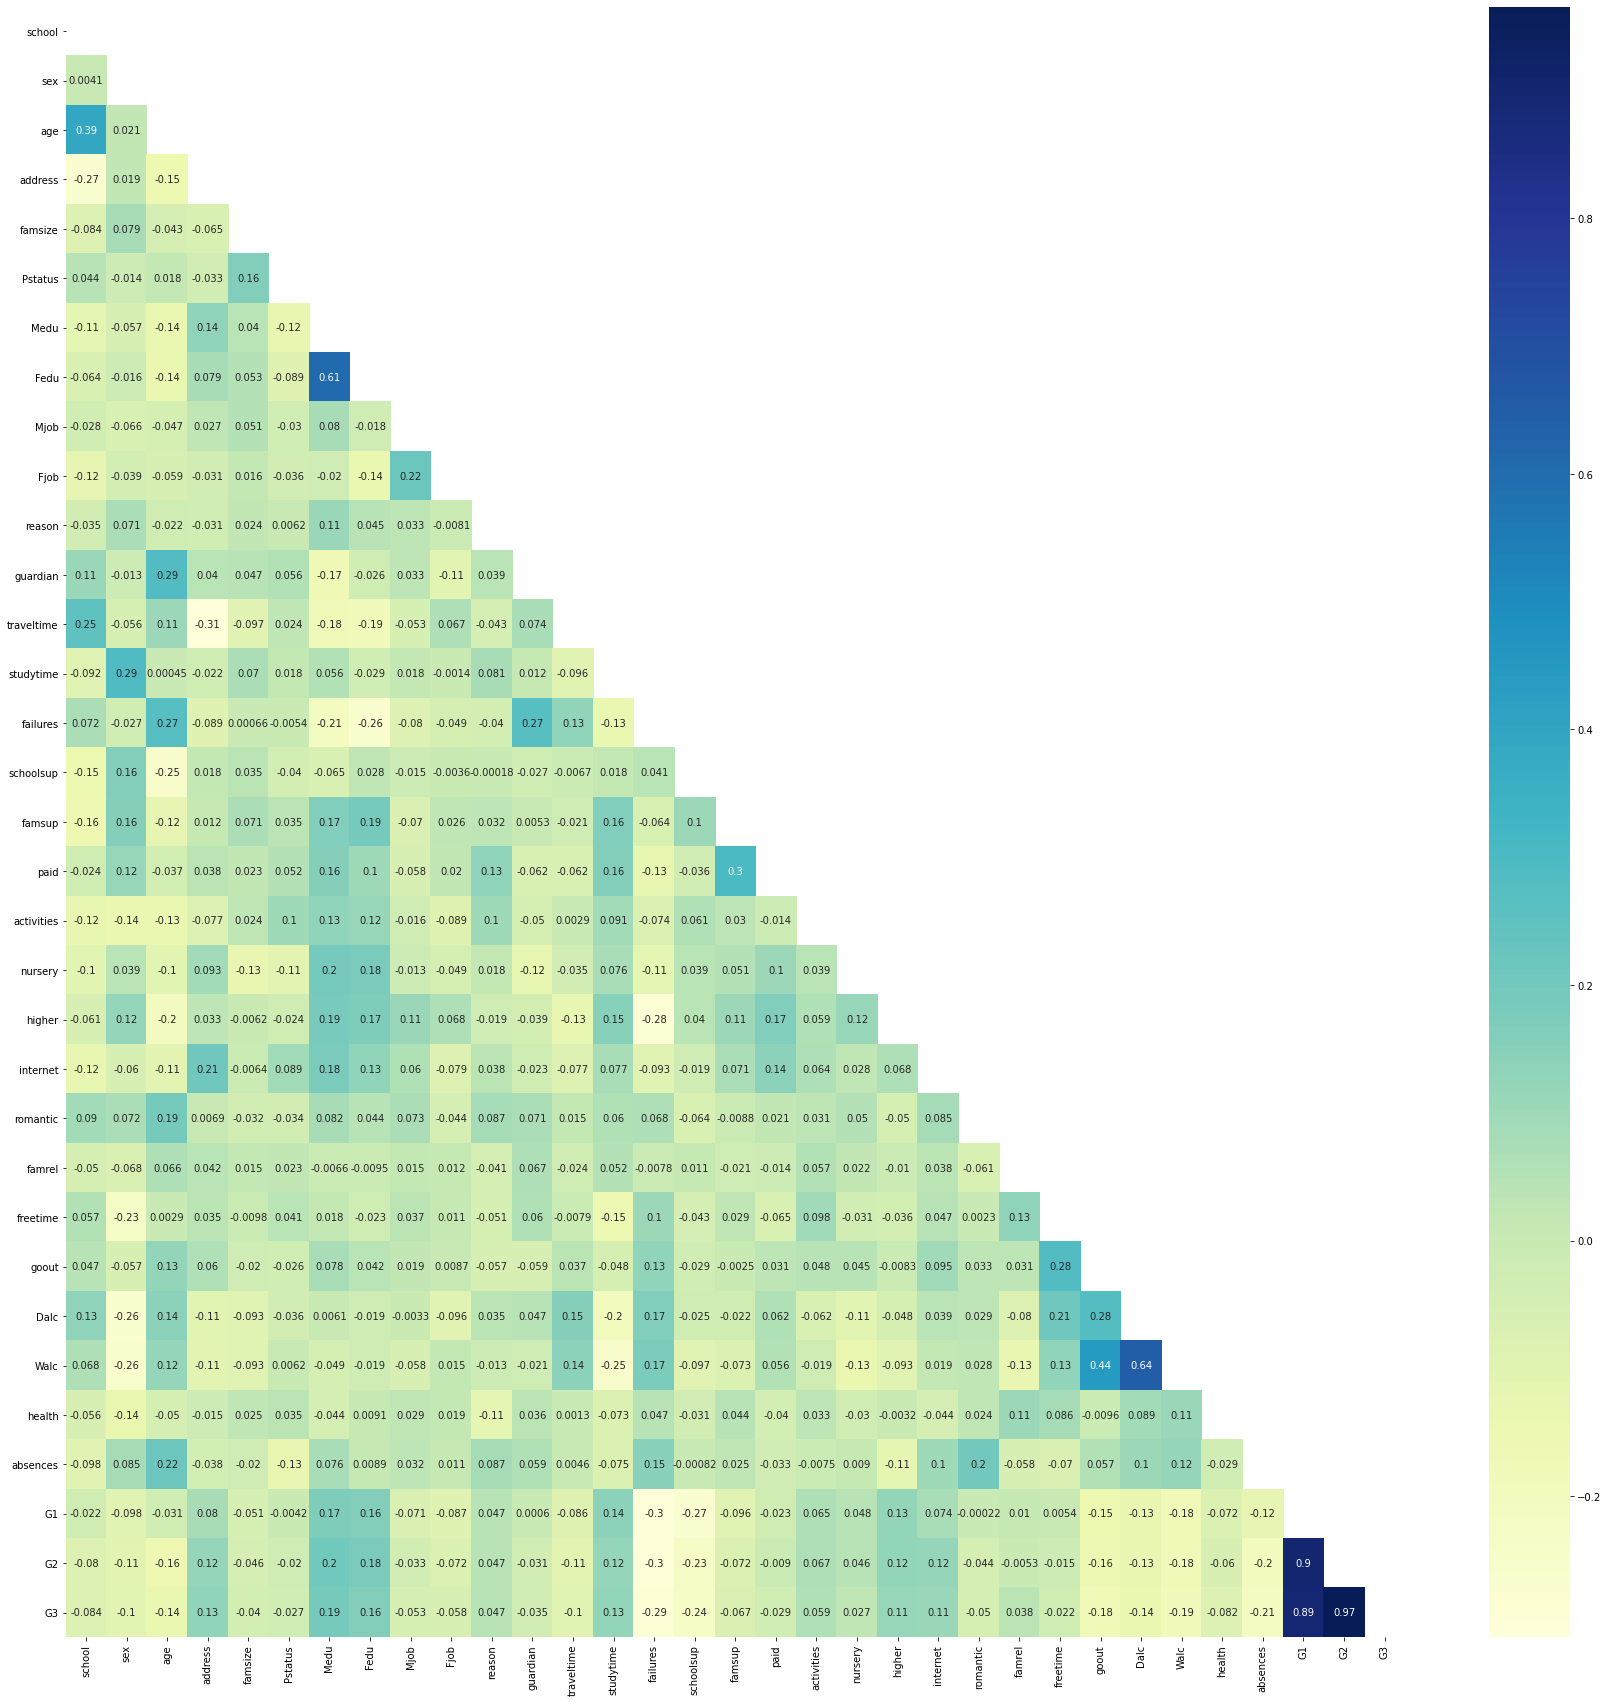

In [66]:
# check correlation between column
correlation_between_column = df.corr()
upper_triangle_corr = np.triu(correlation_between_column)

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(correlation_between_column, annot = True, cmap="YlGnBu",ax=ax,annot_kws={"size":10},mask=upper_triangle_corr)

Based on this heatmap, Dalc & Walc variables have a high correlation with goout, so i will choose goout for regression and drop Dalc & Walc column. 



# REGRESSION

Convert categorical variables to numerical ones

In [ ]:
#convert categorical variables to numerical ones
df['school']=df['school'].map({'GP':0, 'MS':1})
df['sex']=df['sex'].map({'M':0 ,'F':1})
df['address']=df['address'].map({'R':0 ,'U':1})
df['famsize']=df['famsize'].map({'LE3':0 ,'GT3':1})
df['Pstatus']=df['Pstatus'].map({'A':0 ,'T':1})
df['Mjob']=df['Mjob'].map({'at_home':0 ,'services':1, 'teacher':2, 'health':3, 'other':4})
df['Fjob']=df['Fjob'].map({'at_home':0 ,'services':1, 'teacher':2, 'health':3, 'other':4})
df['famsup']=df['famsup'].map({'no':0, 'yes':1})
df['reason']=df['reason'].map({'course':0 ,'home':1, 'reputation':2, 'other':3})
df['guardian']=df['guardian'].map({'mother':0 ,'father':1, 'other':2})
df['schoolsup']=df['schoolsup'].map({'no':0, 'yes':1})
df['paid']=df['paid'].map({'no':0, 'yes':1})
df['activities']=df['activities'].map({'no':0, 'yes':1})
df['nursery']=df['nursery'].map({'no':0, 'yes':1})
df['higher']=df['higher'].map({'no':0, 'yes':1})
df['internet']=df['internet'].map({'no':0, 'yes':1})
df['romantic']=df['romantic'].map({'no':0, 'yes':1})

G3 (final year grade) as a output variable and the others as input, except Dalc and Walc because they have a high correlation with goout.

In [67]:
#prepare the data for regression
target_array = df[['G3']]
final_feature_array = df.drop(['G3','Dalc','Walc'], axis=1)


In [80]:
# split the data into test and train
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    final_feature_array,
    target_array,
    train_size=0.8,
    random_state=0
    )

In [81]:
# check the shape data
print('Shape Data X Train:')
print(X_train.shape)
print('\nShape Data X Test:')
print(X_test.shape)
print('\nShape Data y Train:')
print(y_train.shape)
print('\nShape Data y Test:')
print(y_test.shape)

Shape Data X Train:
(285, 30)

Shape Data X Test:
(72, 30)

Shape Data y Train:
(285, 1)

Shape Data y Test:
(72, 1)


In [82]:
# load the algorithm
regression_model = linear_model.LinearRegression()

In [83]:
# train the data
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# predict the X using trained model
y_train_pred = regression_model.predict(X_train)
y_test_pred = regression_model.predict(X_test)
target_array_pred = regression_model.predict(final_feature_array)

# Check the result

In [84]:
# model result
print('Coefficients:\n',regression_model.coef_)
# print('\n')
print('Intercept:',regression_model.intercept_)

Coefficients:
 [[-0.14574976  0.0455885   0.01491392  0.18723434  0.03254231 -0.24896982
   0.0436391  -0.09802714 -0.05140572  0.01597594  0.04807697 -0.11482295
   0.06246928 -0.03113566 -0.0159283  -0.14262449  0.11053446 -0.19239554
  -0.01742843 -0.11679071  0.06403389  0.10078098 -0.0174837   0.17305945
  -0.02310706 -0.05694036 -0.05847087 -0.01434909  0.12739651  0.86108806]]
Intercept: [0.20896922]


In [87]:
# check the raw prediction data & compare with real data
print('Real Data')
print(y_train[:5])
print('\n Predicted Data')
print(y_train_pred[:5])

Real Data
     G3
272  11
344  10
373   5
155   8
21   15

 Predicted Data
[[11.45629067]
 [10.71006538]
 [ 4.84311462]
 [ 8.1953611 ]
 [14.91826097]]


In [75]:
# check the data in the form of dataframe
final_with_pred_df = df.copy()
final_with_pred_df['G3_predicted'] = target_array_pred.reshape(-1,)
final_with_pred_df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3_predicted
0,0,1,18,1,1,0,4,4,0,2,0,0,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,6.361630
1,0,1,17,1,1,1,1,1,0,4,0,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,5.983910
2,0,1,15,1,0,1,1,1,0,4,3,0,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,8.206307
3,0,1,15,1,1,1,4,2,3,1,1,0,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,14.241936
4,0,1,16,1,1,1,3,3,4,4,1,1,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,9.492483


In [76]:
# evaluate regression model - RMSE
rmse_training = mean_squared_error(y_true=y_train,y_pred=y_train_pred,squared=False)
rmse_test = mean_squared_error(y_true=y_test,y_pred=y_test_pred,squared=False)
print('RMSE Training Data: {}'.format(rmse_training))
print('RMSE Test Data: {}'.format(rmse_test))

RMSE Training Data: 0.75744830104998
RMSE Test Data: 0.8970368946395844


In [77]:
predicted = regression_model.predict(X_test)
print ("MSE :", metrics.mean_squared_error(y_test,predicted))

MSE : 0.8046751903446288


In [78]:
# evaluate regression model - R squared
print('R^2 score:',regression_model.score(X_train, y_train))

R^2 score: 0.945799118134537


With this model i got R^2 Score: 0.94

# Check model's performance

In [92]:
# - Test prediction
performance = pd.DataFrame(y_test_pred, columns=['Prediction'])
# - Target data
y_test = y_test.reset_index(drop=True)
performance['Target'] = y_test
# - The difference in %
performance['Difference (%)']= np.absolute((performance['Target'] 
                                            - performance['Prediction'])/
                                           performance['Target']*100)
performance.head()

,Prediction,Target,Difference (%)
0,12.290111,11,11.728279
1,10.044403,10,0.444028
2,8.250467,8,3.130840
3,11.581166,12,3.490281
4,7.262527,8,9.218415


In [93]:
performance['Difference (%)'].mean()

7.137851712095137

Mean Difference result is 7.1%

# **CLASSIFICATION**

In [106]:
# Use average of G1, G2 and G3 as target column 
df['G_AVG']= round((df['G1']+df['G2']+df['G3'])/3, 2)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G_AVG,Goodstudent
0,0,1,18,1,1,0,4,4,0,2,0,0,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,5.67,0
1,0,1,17,1,1,1,1,1,0,4,0,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,5.33,0
2,0,1,15,1,0,1,1,1,0,4,3,0,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,8.33,0
3,0,1,15,1,1,1,4,2,3,1,1,0,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,14.67,0
4,0,1,16,1,1,1,3,3,4,4,1,1,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,8.67,0


In [107]:
#The student that have average score > 15 is good student and <= 15 is bad student
df['Goodstudent']= np.where(df['G_AVG'] > 15, 1, 0)
df.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G_AVG,Goodstudent
0,0,1,18,1,1,0,4,4,0,2,0,0,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,5.67,0
1,0,1,17,1,1,1,1,1,0,4,0,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,5.33,0
2,0,1,15,1,0,1,1,1,0,4,3,0,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,8.33,0
3,0,1,15,1,1,1,4,2,3,1,1,0,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,14.67,0
4,0,1,16,1,1,1,3,3,4,4,1,1,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,8.67,0
5,0,0,16,1,0,1,4,3,1,4,2,0,1,2,0,0,1,1,1,1,1,1,0,5,4,2,1,2,5,10,15,15,15,15.00,0
6,0,0,16,1,0,1,2,2,4,4,1,0,1,2,0,0,0,0,0,1,1,1,0,4,4,4,1,1,3,0,12,12,11,11.67,0
7,0,1,17,1,1,0,4,4,4,2,1,0,2,2,0,1,1,0,0,1,1,0,0,4,1,4,1,1,1,6,6,5,6,5.67,0
8,0,0,15,1,0,0,3,2,1,4,1,0,1,2,0,0,1,1,0,1,1,1,0,4,2,2,1,1,1,0,16,18,19,17.67,1
9,0,0,15,1,1,1,3,4,4,4,1,0,1,2,0,0,1,1,1,1,1,1,0,5,5,1,1,1,5,0,14,15,15,14.67,0


In [97]:
# choose target and feature array
target_array = df['Goodstudent']
final_feature_array = df.drop(['Goodstudent'], axis=1)

In [98]:
# split the data into test and train
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    final_feature_array,
    target_array,
    train_size=0.8,
    random_state=0
    )

In [99]:
# load the algorithm
classification_model = neighbors.KNeighborsClassifier(n_neighbors=10)

In [100]:
# train the data
classification_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [101]:
# predict the X using trained model
y_train_pred = classification_model.predict(X_train)
y_test_pred = classification_model.predict(X_test)
target_array_pred = classification_model.predict(final_feature_array)

In [102]:
# check the raw prediction data & compare with real data
print('Real Data')
print(y_train[:5])
print('\n Predicted Data')
print(y_train_pred[:5])

Real Data
272    0
344    0
373    0
155    0
21     0
Name: Goodstudent, dtype: int64

 Predicted Data
[0 0 0 0 0]


In [103]:
final_with_pred_df = df.copy()
final_with_pred_df['Goodstudent_predicted'] = target_array_pred.reshape(-1,)
final_with_pred_df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G_AVG,Goodstudent,Goodstudent_predicted
0,0,1,18,1,1,0,4,4,0,2,0,0,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,5.67,0,0
1,0,1,17,1,1,1,1,1,0,4,0,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,5.33,0,0
2,0,1,15,1,0,1,1,1,0,4,3,0,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,8.33,0,0
3,0,1,15,1,1,1,4,2,3,1,1,0,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,14.67,0,0
4,0,1,16,1,1,1,3,3,4,4,1,1,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,8.67,0,0


In [104]:
# evaluate classification model - accuracy
accuracy_training = metrics.accuracy_score(y_train,y_train_pred)
accuracy_test = metrics.accuracy_score(y_test,y_test_pred)

print('Accuracy Training Data: {}'.format(accuracy_training))
print('Accuracy Test Data: {}'.format(accuracy_test))

Accuracy Training Data: 0.9543859649122807
Accuracy Test Data: 0.9444444444444444
